In [1]:
! pip install transformers

In [2]:
# Import necessary libraries
import numpy as np
import re
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


# Misc.
import warnings
warnings.filterwarnings('ignore')

2025-05-08 02:47:38.539977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746672458.720957      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746672458.772474      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
df = pd.read_csv('/kaggle/input/amazon-book/sample.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         22000 non-null  object 
 1   review/score  22000 non-null  float64
 2   review/text   22000 non-null  object 
 3   authors       21851 non-null  object 
 4   categories    21912 non-null  object 
 5   ratingsCount  22000 non-null  float64
 6   word_count    22000 non-null  int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 1.2+ MB


In [6]:
df.head()

,Title,review/score,review/text,authors,categories,ratingsCount,word_count
0,Summer Sisters : A Novel,5.0,This was the best Judy Blume book I've ever re...,Judy Blume,Fiction,61.0,111
1,Fugitive from the Cubicle Police,5.0,Another hilarious Dilbert compilation. With bo...,Scott Adams,Humor,9.0,100
2,"Just Above a Whisper (Tucker Mills Trilogy, Bo...",5.0,I have all three books in the Tucker Mills Tri...,Lori Wick,Fiction,12.0,82
3,Norstrilia,4.0,There was a time when science fiction was a ve...,Cordwainer Smith,Fiction,3.0,477
4,The Perfect Husband,3.0,"I read Perfect Husband on my Kindle, and since...",Lisa Gardner,Fiction,27.0,335


In [7]:
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)                     # HTML tags
    text = re.sub(r'http\S+|www\.\S+', '', text)            # URLs
    text = re.sub(r'\S+@\S+', '', text)                     # Emails
    text = re.sub(r'@\w+|#\w+', '', text)                   # Mentions & Hashtags
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)            # Special characters
    return text
df['review/text']=df['review/text'].apply(clean_text)

In [8]:
def to_sentiment(rating):
    
    rating = int(rating)
    
    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

# Apply to the dataset 
df['sentiment'] = df['review/score'].apply(to_sentiment)

In [9]:
df.head()

,Title,review/score,review/text,authors,categories,ratingsCount,word_count,sentiment
0,Summer Sisters : A Novel,5.0,This was the best Judy Blume book I ve ever re...,Judy Blume,Fiction,61.0,111,2
1,Fugitive from the Cubicle Police,5.0,Another hilarious Dilbert compilation With bo...,Scott Adams,Humor,9.0,100,2
2,"Just Above a Whisper (Tucker Mills Trilogy, Bo...",5.0,I have all three books in the Tucker Mills Tri...,Lori Wick,Fiction,12.0,82,2
3,Norstrilia,4.0,There was a time when science fiction was a ve...,Cordwainer Smith,Fiction,3.0,477,2
4,The Perfect Husband,3.0,I read Perfect Husband on my Kindle and since...,Lisa Gardner,Fiction,27.0,335,1


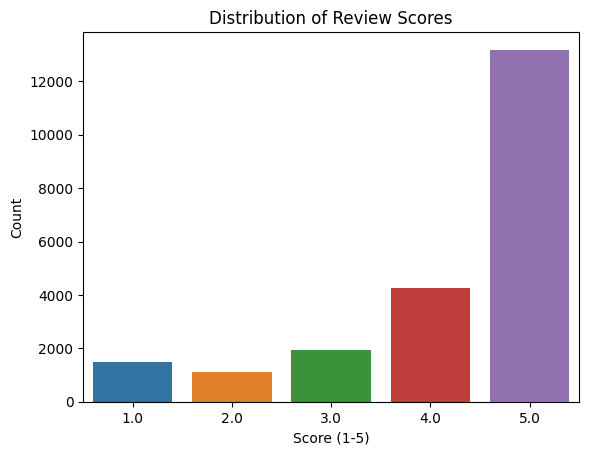

In [10]:
sns.countplot(data=df, x='review/score')  # Sửa thành tên cột chính xác
plt.xlabel('Score (1-5)')
plt.ylabel('Count')
plt.title('Distribution of Review Scores')
plt.show()

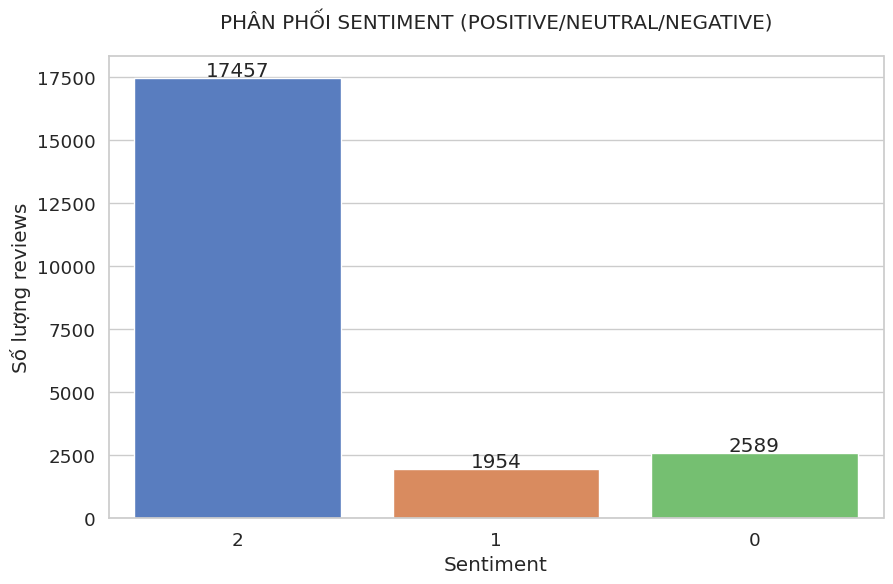

In [11]:
# Thiết lập style đồ thị (nếu chưa có)
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ phân phối
ax = sns.countplot(data=df, x="sentiment", order=[2, 1, 0])

# Thêm tiêu đề và label
plt.title("PHÂN PHỐI SENTIMENT (POSITIVE/NEUTRAL/NEGATIVE)", pad=20)
plt.xlabel("Sentiment")
plt.ylabel("Số lượng reviews")

# Hiển thị số lượng trên mỗi cột
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.0f}", 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha="center", va="center", 
        xytext=(0, 5), 
        textcoords="offset points"
    )

plt.show()

### Sentiment Analysis with BERT

#### Model

In [12]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [14]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df['review/text']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

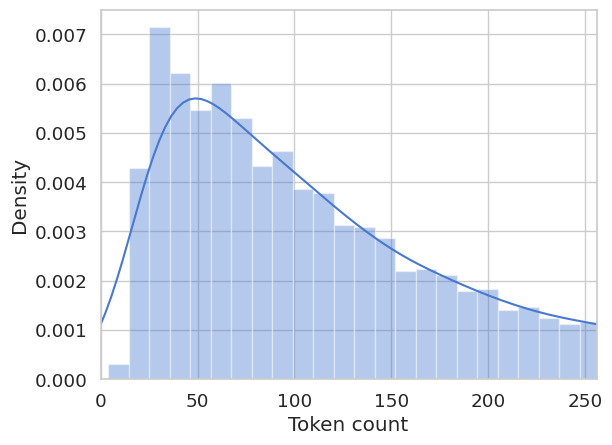

In [15]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [16]:
MAX_LEN = 512

In [17]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [18]:
df_sentiment = df[['review/text', 'sentiment']]

In [19]:
df_train, df_test = train_test_split(df_sentiment, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(17600, 2) (2200, 2) (2200, 2)


In [20]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df['review/text'].to_numpy(),
        targets=df['sentiment'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [21]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [22]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


In [23]:
bert_model = BertModel.from_pretrained(MODEL_NAME)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [24]:
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        # Không unpack như tuple
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = output.pooler_output  # đúng cách
        output = self.drop(pooled_output)
        return self.out(output)

In [25]:
# Instantiate the model and move to classifier
model = SentimentClassifier(3)
model = model.to(device)

In [26]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


In [27]:
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [28]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [29]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [30]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
     
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.429876223964278 accuracy 0.8465909090909091
Val   loss 0.38575918933349673 accuracy 0.8740909090909091

Epoch 2/10
----------
Train loss 0.28198415048547426 accuracy 0.9024431818181818
Val   loss 0.4449778460877259 accuracy 0.875

Epoch 3/10
----------
Train loss 0.20463126771691764 accuracy 0.9371590909090909
Val   loss 0.5404852454591057 accuracy 0.8713636363636363

Epoch 4/10
----------
Train loss 0.15173954187828878 accuracy 0.9594318181818182
Val   loss 0.7007094604693744 accuracy 0.87

Epoch 5/10
----------
Train loss 0.10326768800886137 accuracy 0.9748295454545455
Val   loss 0.7874719840048414 accuracy 0.8631818181818182

Epoch 6/10
----------
Train loss 0.07317323736669178 accuracy 0.9834090909090909
Val   loss 0.8369155328236166 accuracy 0.8763636363636363

Epoch 7/10
----------
Train loss 0.05466490777423711 accuracy 0.9885227272727273
Val   loss 0.8485672971599844 accuracy 0.8772727272727273

Epoch 8/10
----------
Train loss 0.0326347138475

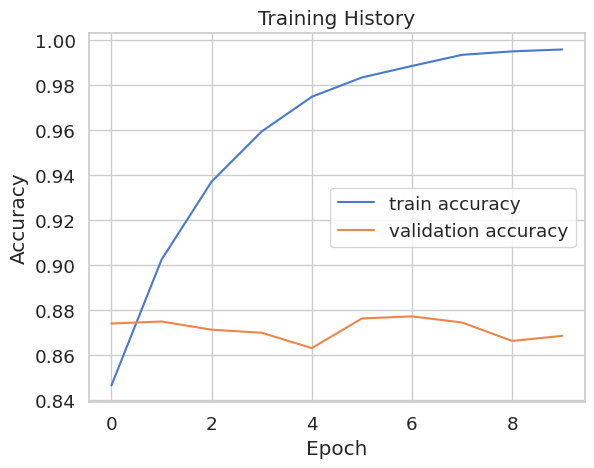

In [31]:
# Chuyển đổi dữ liệu từ GPU tensor sang numpy array
plt.plot([t.cpu().numpy() for t in history['train_acc']], label='train accuracy')
plt.plot([t.cpu().numpy() for t in history['val_acc']], label='validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.show()

In [32]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8613636363636363

In [33]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [34]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [37]:
print(classification_report(y_test, y_pred, target_names=["class 0", "class 1", "class 2"]))

              precision    recall  f1-score   support

     class 0       0.75      0.66      0.70       264
     class 1       0.42      0.42      0.42       205
     class 2       0.93      0.94      0.94      1731

    accuracy                           0.86      2200
   macro avg       0.70      0.67      0.69      2200
weighted avg       0.86      0.86      0.86      2200



In [41]:
class_names = ["class 0", "class 1", "class 2"]

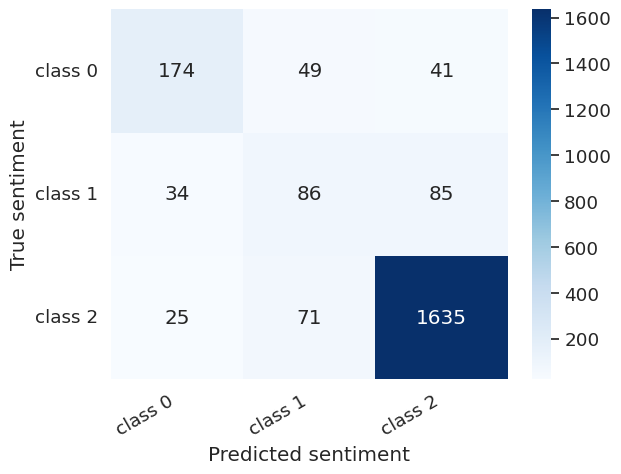

In [42]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [43]:
review_text = "I love completing my todos! Best app ever!!!"

In [44]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [45]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)

_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : class 2
